In [0]:
## Baselines
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:

import six
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import BatchNormalization,DepthwiseConv2D
from tensorflow.keras.layers import Flatten,LeakyReLU,Layer,ReLU,Lambda,Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping,Callback
def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return Add()([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(1, 1), initial_kernel_size=(3, 3), initial_pooling=None,
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape

    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation=activation,
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model


def ResNet18(input_shape, classes,droput=0.25):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2])


def ResNet34(input_shape, classes,dropout=0.25):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3])


def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])


def ResNet101(input_shape, classes):
    """ResNet with 101 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 23, 3])


def ResNet152(input_shape, classes):
    """ResNet with 152 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 8, 36, 3])

In [0]:

def WideResidualNetwork(depth=28, width=8, dropout_rate=0.25,
                        include_top=True, weights=None,
                        input_tensor=None, input_shape=None,
                        classes=10, activation='softmax'):
    """Instantiate the Wide Residual Network architecture,
        optionally loading weights pre-trained
        on CIFAR-10. Note that when using TensorFlow,
        for best performance you should set
        `image_dim_ordering="tf"` in your Keras config
        at ~/.keras/keras.json.
        The model and the weights are compatible with both
        TensorFlow and Theano. The dimension ordering
        convention used by the model is the one
        specified in your Keras config file.
        # Arguments
            depth: number or layers in the DenseNet
            width: multiplier to the ResNet width (number of filters)
            dropout_rate: dropout rate
            include_top: whether to include the fully-connected
                layer at the top of the network.
            weights: one of `None` (random initialization) or
                "cifar10" (pre-training on CIFAR-10)..
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(32, 32, 3)` (with `tf` dim ordering)
                or `(3, 32, 32)` (with `th` dim ordering).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 8.
                E.g. `(200, 200, 3)` would be one valid value.
            classes: optional number of classes to classify images
                into, only to be specified if `include_top` is True, and
                if no `weights` argument is specified.
        # Returns
            A Keras model instance.
        """

    if weights not in {'cifar10', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    if weights == 'cifar10' and include_top and classes != 10:
        raise ValueError('If using `weights` as CIFAR 10 with `include_top`'
                         ' as true, `classes` should be 10')

    if (depth - 4) % 6 != 0:
        raise ValueError('Depth of the network must be such that (depth - 4)'
                         'should be divisible by 6.')

    # Determine proper input shape

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_wide_residual_network(classes, img_input, include_top, depth, width,
                                       dropout_rate, activation)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='wide-resnet')

    # load weights    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    if weights == 'cifar10':
        if (depth == 28) and (width == 8) and (dropout_rate == 0.0):
            # Default parameters match. Weights for this model exist:

            if K.image_data_format() == 'channels_first':
                if include_top:
                    h5_file = 'wide_resnet_28_8_th_dim_ordering_th_kernels.h5'
                    weights_path = get_file(h5_file,
                                            TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    h5_file = 'wide_resnet_28_8_th_dim_ordering_th_kernels_no_top.h5'
                    weights_path = get_file(h5_file,
                                            TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('You are using the TensorFlow backend, yet you '
                                  'are using the Theano '
                                  'image dimension ordering convention '
                                  '(`image_dim_ordering="th"`). '
                                  'For best performance, set '
                                  '`image_dim_ordering="tf"` in '
                                  'your Keras config '
                                  'at ~/.keras/keras.json.')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    h5_file = 'wide_resnet_28_8_tf_dim_ordering_tf_kernels.h5'
                    weights_path = get_file(h5_file,
                                            TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    h5_file = 'wide_resnet_28_8_tf_dim_ordering_tf_kernels_no_top.h5'
                    weights_path = get_file(h5_file,
                                            TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


def __conv1_block(input):
    x = Conv2D(16, (3, 3), padding='same')(input)

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    return x


def __conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create
    # convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init._shape[1] != 16 * k:
            init = Conv2D(16 * k, (1, 1), activation='linear', padding='same')(init)
    else:
        if init._shape[-1] != 16 * k:
            init = Conv2D(16 * k, (1, 1), activation='linear', padding='same')(init)

    x = Conv2D(16 * k, (3, 3), padding='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = Conv2D(16 * k, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = Add()([init, x])
    return m


def __conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 32 * k, else
    # create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init.shape[1] != 32 * k:
            init = Conv2D(32 * k, (1, 1), activation='linear', padding='same')(init)
    else:
        if init.shape[-1] != 32 * k:
            init = Conv2D(32 * k, (1, 1), activation='linear', padding='same')(init)

    x = Conv2D(32 * k, (3, 3), padding='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = Conv2D(32 * k, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = Add()([init, x])
    return m


def ___conv4_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 64 * k, else
    # create convolution2d for this input
    if channel_axis==1:
        if init.shape[1] != 64 * k:
            init = Conv2D(64 * k, (1, 1), activation='linear', padding='same')(init)
    else:
        if init.shape[-1] != 64 * k:
            init = Conv2D(64 * k, (1, 1), activation='linear', padding='same')(init)

    x = Conv2D(64 * k, (3, 3), padding='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = Conv2D(64 * k, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = Add()([init, x])
    return m


def __create_wide_residual_network(nb_classes, img_input, include_top, depth=28,
                                   width=8, dropout=0.0, activation='softmax'):
    ''' Creates a Wide Residual Network with specified parameters
    Args:
        nb_classes: Number of output classes
        img_input: Input tensor or layer
        include_top: Flag to include the last dense layer
        depth: Depth of the network. Compute N = (n - 4) / 6.
               For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
               For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
               For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
        width: Width of the network.
        dropout: Adds dropout if value is greater than 0.0
    Returns:a Keras Model
    '''

    N = (depth - 4) // 6

    x = __conv1_block(img_input)
    nb_conv = 4

    for i in range(N):
        x = __conv2_block(x, width, dropout)
        nb_conv += 2

    x = MaxPooling2D((2, 2))(x)

    for i in range(N):
        x = __conv3_block(x, width, dropout)
        nb_conv += 2

    x = MaxPooling2D((2, 2))(x)

    for i in range(N):
        x = ___conv4_block(x, width, dropout)
        nb_conv += 2

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, activation=activation)(x)

    return x

In [0]:

class ShakeShake(Layer):
    """ Shake-Shake-Image Layer """

    def __init__(self, **kwargs):
        super(ShakeShake, self).__init__(**kwargs)

    def build(self, input_shape):
        super(ShakeShake, self).build(input_shape)

    def call(self, x):
        # unpack x1 and x2
        assert isinstance(x, list)
        x1, x2 = x
        # create alpha and beta
        batch_size = K.shape(x1)[0]
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        beta = K.random_uniform((batch_size, 1, 1, 1))
        # shake-shake during training phase
        def x_shake():
            return beta * x1 + (1 - beta) * x2 + K.stop_gradient((alpha - beta) * x1 + (beta - alpha) * x2)
        # even-even during testing phase
        def x_even():
            return 0.5 * x1 + 0.5 * x2
        return K.in_train_phase(x_shake, x_even)

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        return input_shape[0]

In [0]:
from tensorflow.keras.regularizers import l2
l2 = l2(1e-4)


def create_residual_branch(x, filters, stride):
    """ Regular Branch of a Residual network: ReLU -> Conv2D -> BN repeated twice """
    x = ReLU()(x)
    x =Conv2D(filters, kernel_size=3, strides=stride, padding='same',
                            kernel_initializer='he_normal', kernel_regularizer=l2,
                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same',
                            kernel_initializer='he_normal', kernel_regularizer=l2,
                            use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def create_residual_shortcut(x, filters, stride):
    """ Shortcut Branch used when downsampling from Shake-Shake regularization """
    x = ReLU()(x)
    x1 = Lambda(lambda y: y[:, 0:-1:stride, 0:-1:stride, :])(x)
    x1 = Conv2D(filters // 2, kernel_size=1, strides=1, padding='valid',
                             kernel_initializer='he_normal', kernel_regularizer=l2,
                             use_bias=False)(x1)
    x2 = Lambda(lambda y: y[:, 1::stride, 1::stride, :])(x)
    x2 = Conv2D(filters // 2, kernel_size=1, strides=1, padding='valid',
                             kernel_initializer='he_normal', kernel_regularizer=l2,
                             use_bias=False)(x2)
    x = Concatenate()([x1, x2])
    x = BatchNormalization()(x)
    return x


def create_residual_block(x, filters, stride=1):
    """ Residual Block with Shake-Shake regularization and shortcut """
    x1 = create_residual_branch(x, filters, stride)
    x2 = create_residual_branch(x, filters, stride)
    if stride > 1: x = create_residual_shortcut(x, filters, stride)
    return Add()([x, ShakeShake()([x1, x2])])


def create_residual_layer(x, filters, blocks, stride):
    """ Layer repeating Residual Blocks """
    x = create_residual_block(x, filters, stride)
    for i in range(1, blocks):
        x = create_residual_block(x, filters, 1)
    return x

In [0]:

def create_shakeshake(n_classes, n_blocks=[3, 4, 6, 3], activation='softmax'):
    """ Residual Network with Shake-Shake regularization modeled after ResNet32 """
    # Input and first convolutional layer
    x_in = Input(shape=(48, 48, 1))
    x = Conv2D(64, kernel_size=7, strides=2, padding='same',
                            kernel_initializer='he_normal', kernel_regularizer=l2,
                            use_bias=False)(x_in)
    x =BatchNormalization()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    # Three stages of four residual blocks
    x = create_residual_layer(x, 64, n_blocks[0], 1)
    x = create_residual_layer(x, 128, n_blocks[1], 2)
    x = create_residual_layer(x, 256, n_blocks[2], 2)
    x = create_residual_layer(x, 512, n_blocks[3], 2)
    # Output pooling and dense layer
    x =ReLU()(x)
    x = GlobalAveragePooling2D()(x)
    x_out = Dense(n_classes, activation=activation, kernel_initializer='he_normal')(x)
    return Model(x_in, x_out)

In [0]:
def channel_split(x, name=''):
    # equipartition
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio,strides=2,stage=1,block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}/block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x



def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(224,224,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=1000):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))

    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    if input_tensor:
        inputs = get_source_inputs(input_tensor)

    else:
        inputs = img_input

    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('', by_name=True)

    return model

In [0]:
shake_shake = create_shakeshake(10,n_blocks=[3, 4, 6, 3])

In [0]:
resnet18 = ResNet18((28,28,1),10)

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [0]:
from tensorflow.keras.datasets import fashion_mnist

In [0]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

In [0]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0


In [0]:
from tensorflow.keras.utils import to_categorical

In [0]:

 
# one-hot encode the training and testing labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

In [0]:
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [0]:
from tensorflow.keras.optimizers import SGD
NUM_EPOCHS = 25
INIT_LR = 1e-2
BS = 256

opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)


In [0]:
resnet18.compile(loss="categorical_crossentropy", optimizer='adam',
	metrics=["accuracy"])

In [0]:
H = resnet18.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=BS, epochs=NUM_EPOCHS)

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 19s 311us/sample - loss: 1.2554 - accuracy: 0.8659 - val_loss: 2.1869 - val_accuracy: 0.7532
Epoch 2/25
60000/60000 [==============================] - 12s 202us/sample - loss: 0.9021 - accuracy: 0.9145 - val_loss: 0.9345 - val_accuracy: 0.8786
Epoch 3/25
50688/60000 [========================>.....] - ETA: 1s - loss: 0.7231 - accuracy: 0.9297

KeyboardInterrupt: ignored

In [0]:
preds = resnet18.predict(testX)

In [0]:
resnet18.save('resnet18-1.h5')

In [0]:
from sklearn.metrics import classification_report

In [0]:
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),
	target_names=labelNames))

              precision    recall  f1-score   support

         top       0.87      0.86      0.86      1000
     trouser       0.99      0.98      0.99      1000
    pullover       0.82      0.88      0.85      1000
       dress       0.90      0.92      0.91      1000
        coat       0.89      0.79      0.84      1000
      sandal       0.97      0.97      0.97      1000
       shirt       0.74      0.76      0.75      1000
     sneaker       0.95      0.98      0.96      1000
         bag       0.98      0.98      0.98      1000
  ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [0]:
wide_resnet = WideResidualNetwork(input_shape=(28,28,1))

In [0]:
wide_resnet.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [0]:
H_wide_resnet = wide_resnet.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=BS, epochs=NUM_EPOCHS)

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 127s 2ms/sample - loss: 0.6980 - accuracy: 0.7548 - val_loss: 0.6237 - val_accuracy: 0.7849
Epoch 2/25
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.4153 - accuracy: 0.8482 - val_loss: 0.4909 - val_accuracy: 0.8344
Epoch 3/25
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.3509 - accuracy: 0.8711 - val_loss: 0.4328 - val_accuracy: 0.8504
Epoch 4/25
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.3124 - accuracy: 0.8860 - val_loss: 0.3745 - val_accuracy: 0.8705
Epoch 5/25
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.2885 - accuracy: 0.8957 - val_loss: 0.3682 - val_accuracy: 0.8717
Epoch 6/25
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.2698 - accuracy: 0.9011 - val_loss: 0.3530 - val_accuracy: 0.8754
Epoch 7/25
60000/60000 [==========================

In [0]:
wide_resnet.save('wide_resnet.h5')

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2

In [0]:
def VGG_mini(input_shape,classes):

  model3=Sequential()
  model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", 
            input_shape=input_shape, activation='relu'))
  model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'))
  model3.add(MaxPooling2D(pool_size=(3, 3)))
  model3.add(Dropout(0.25))
  model3.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))
  model3.add(Conv2D(filters=64, kernel_size=(3, 3), padding="valid", activation='relu'))
  model3.add(MaxPooling2D(pool_size=(3, 3)))
  model3.add(Dropout(0.25))
  model3.add(Flatten())
  model3.add(Dense(256))
  model3.add(LeakyReLU())
  model3.add(Dropout(0.25))
  model3.add(Dense(256))
  model3.add(LeakyReLU())
  #model2.add(Dropout(0.5))
  model3.add(Dense(classes, activation='softmax'))
  return model3

In [0]:
vgg = VGG_mini((28,28,1),10)

In [0]:
early_stopper = EarlyStopping(patience=10,restore_best_weights=True)
vgg.compile(loss="categorical_crossentropy", optimizer='adam',
	metrics=["accuracy"])
vgg_Hist = vgg.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=BS, epochs=50,callbacks=[early_stopper])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 50us/sample - loss: 0.5018 - accuracy: 0.8146 - val_loss: 0.3941 - val_accuracy: 0.8547
Epoch 2/50
60000/60000 [==============================] - 2s 38us/sample - loss: 0.3940 - accuracy: 0.8552 - val_loss: 0.3322 - val_accuracy: 0.8793
Epoch 3/50
60000/60000 [==============================] - 2s 38us/sample - loss: 0.3461 - accuracy: 0.8716 - val_loss: 0.2985 - val_accuracy: 0.8884
Epoch 4/50
60000/60000 [==============================] - 2s 39us/sample - loss: 0.3150 - accuracy: 0.8839 - val_loss: 0.2776 - val_accuracy: 0.8978
Epoch 5/50
60000/60000 [==============================] - 2s 38us/sample - loss: 0.2920 - accuracy: 0.8921 - val_loss: 0.2755 - val_accuracy: 0.8996
Epoch 6/50
60000/60000 [==============================] - 2s 38us/sample - loss: 0.2803 - accuracy: 0.8968 - val_loss: 0.2603 - val_accuracy: 0.9074
Epoch 7/50
60000/60000 [==============================] 

KeyboardInterrupt: ignored

In [0]:
vgg.save('vgg.h5')

In [0]:
def plot_progress(history_cnn):
  acc = history_cnn.history['accuracy']
  val_acc = history_cnn.history['val_accuracy']
  loss = history_cnn.history['loss']
  val_loss = history_cnn.history['val_loss']
  
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, "r", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.legend()
  plt.figure()
  
  plt.plot(epochs, loss, "r", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.legend()
  plt.show()

In [0]:
import matplotlib.pyplot as plt
plot_progress

TypeError: ignored

In [0]:
vgg_Hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
resized_X,Resized_Y,

In [0]:
resized_trainX = tf.image.resize(trainX,(48,48))
resized_testX = tf.image.resize(testX,(48,48))

In [0]:
import matplotlib.pyplot as pl

AttributeError: ignored

In [0]:
mobile_net = MobileNetV2(input_shape=(48,48,1),classes=10,weights=None)

In [0]:
early_stopper = EarlyStopping(patience=10,restore_best_weights=True)
mobile_net.compile(loss="categorical_crossentropy", optimizer='adam',
	metrics=["accuracy"])
mobile_Hist = mobile_net.fit(resized_trainX, trainY,
	validation_data=(resized_testX, testY),
	batch_size=BS, epochs=50,callbacks=[early_stopper])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 21s 343us/sample - loss: 0.6089 - accuracy: 0.7710 - val_loss: 2.3111 - val_accuracy: 0.1000
Epoch 2/50
60000/60000 [==============================] - 14s 227us/sample - loss: 0.3469 - accuracy: 0.8714 - val_loss: 2.3406 - val_accuracy: 0.1000
Epoch 3/50
60000/60000 [==============================] - 14s 227us/sample - loss: 0.2874 - accuracy: 0.8945 - val_loss: 2.3970 - val_accuracy: 0.1000
Epoch 4/50
 8960/60000 [===>..........................] - ETA: 10s - loss: 0.2499 - accuracy: 0.9073WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: ignored

In [0]:
early_stopper = EarlyStopping(patience=10,restore_best_weights=True)
shake_shake.compile(loss="categorical_crossentropy", optimizer='adam',
	metrics=["accuracy"])
shake_hist = shake_shake.fit(resized_trainX, trainY,
	validation_data=(resized_testX, testY),
	batch_size=128, epochs=50,callbacks=[early_stopper])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 63s 1ms/sample - loss: 0.4554 - accuracy: 0.9316 - val_loss: 0.5684 - val_accuracy: 0.9174
Epoch 2/50
60000/60000 [==============================] - 49s 811us/sample - loss: 0.4717 - accuracy: 0.9325 - val_loss: 0.5406 - val_accuracy: 0.9128
Epoch 3/50
60000/60000 [==============================] - 49s 809us/sample - loss: 0.4221 - accuracy: 0.9360 - val_loss: 0.4502 - val_accuracy: 0.9207
Epoch 4/50
60000/60000 [==============================] - 48s 806us/sample - loss: 0.4458 - accuracy: 0.9323 - val_loss: 0.4883 - val_accuracy: 0.9159
Epoch 5/50
60000/60000 [==============================] - 48s 806us/sample - loss: 0.4455 - accuracy: 0.9338 - val_loss: 0.4872 - val_accuracy: 0.9138
Epoch 6/50
60000/60000 [==============================] - 49s 808us/sample - loss: 0.4014 - accuracy: 0.9375 - val_loss: 0.5221 - val_accuracy: 0.8965
Epoch 7/50
60000/60000 [======================

In [0]:
## BASIC CNN:
def get_basic_cnn():

  input = Input(shape=[28, 28, 1])
  x = Conv2D(32, (5, 5), strides=1, padding='same')(input)
  x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (5, 5), strides=1, padding='same')(x)
  x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
  x = Dropout (0.25)(x)

  x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
  # x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = Dropout (0.5)(x)
  x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
  x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
  x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)

  x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
  x = Dropout (0.35)(x)
  x = Flatten()(x)
  x = Dense(200)(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Dense(10)(x)
  x = Activation('softmax')(x)
  return Model(inputs = input, outputs =x)
basic_cnn = get_basic_cnn()


In [0]:
early_stopper = EarlyStopping(patience=10,restore_best_weights=True)
basic_cnn.compile(loss="categorical_crossentropy", optimizer=SGD(),
	metrics=["accuracy"])

In [0]:
bmodel2=basic_model2(
)


In [0]:
bmodel2.fit(trainX, trainY,
          batch_size=128,
          epochs=2,
          validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 1s 31us/sample - loss: 0.4487 - accuracy: 0.8356 - val_loss: 0.3680 - val_accuracy: 0.8691
Epoch 2/2
48000/48000 [==============================] - 2s 32us/sample - loss: 0.4181 - accuracy: 0.8478 - val_loss: 0.3472 - val_accuracy: 0.8733


In [0]:
basic_cnn.evaluate(testX,testY)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.18233514888584615, 0.9367]

In [0]:
#### Augmentations

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img


In [0]:

import warnings
# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = None
        self.samples = None
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        self.epochs = self.params['epochs']
        self.batch_size = self.params['batch_size']
        self.samples = self.params['samples']
        self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))


class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.
        A port of the Fast.ai implementation for Keras.
        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.
        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.
        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.
                If Positive > 0, will sample from the validation dataset
                If Megative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            save_dir: Optional, String. If passed a directory path, the callback
                will save the running loss and learning rates to two separate numpy
                arrays inside this directory. If the directory in this path does not
                exist, they will be created.
            verbose: Whether to print the learning rate after every batch of training.
        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            # use 5 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.
        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        """
        Loads the training history from the saved numpy files in the given directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        Returns:
            tuple of (losses, learning rates)
        """
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        """
        Plots the schedule from the saved numpy arrays of the loss and learning
        rate values in the specified directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

In [0]:

class SWA(Callback):
    """ Stochastic Weight Averging.
    # Paper
        title: Averaging Weights Leads to Wider Optima and Better Generalization
        link: https://arxiv.org/abs/1803.05407
    # Arguments
        start_epoch:   integer, epoch when swa should start.
        lr_schedule:   string, type of learning rate schedule.
        swa_lr:        float, learning rate for swa sampling.
        swa_lr2:       float, upper bound of cyclic learning rate.
        swa_freq:      integer, length of learning rate cycle.
        verbose:       integer, verbosity mode, 0 or 1.
    """
    def __init__(self, 
                 start_epoch, 
                 lr_schedule='manual', 
                 swa_lr=0.001, 
                 swa_lr2=0.003,
                 swa_freq=1,
                 verbose=0):
        
        super(SWA, self).__init__()
        self.start_epoch = start_epoch - 1
        self.lr_schedule = lr_schedule
        self.swa_lr = swa_lr
        self.swa_lr2 = swa_lr2
        self.swa_freq = swa_freq
        self.verbose = verbose
        
        if start_epoch < 2:
            raise ValueError('"swa_start" attribute cannot be lower than 2.')
            
        schedules = ['manual', 'constant', 'cyclic']
        
        if self.lr_schedule not in schedules:
            raise ValueError('"{}" is not a valid learning rate schedule' \
                             .format(self.lr_schedule))

        if self.lr_schedule == 'cyclic' and self.swa_freq < 2:
            raise ValueError('"swa_freq" must be higher than 1 for cyclic schedule.')

        if self.lr_schedule == 'cyclic' and self.swa_lr > self.swa_lr2:
            raise ValueError('"swa_lr" must be lower than "swa_lr2".')

    def on_train_begin(self, logs=None):
        
        self.epochs = self.params.get('epochs')
        
        if self.start_epoch >= self.epochs - 1:
            raise ValueError('"swa_start" attribute must be lower than "epochs".')

        self.init_lr = K.get_value(self.model.optimizer.lr)

        if self.init_lr < self.swa_lr:
            raise ValueError('"swa_lr" must be lower than rate set in optimizer.')
            
        self._check_batch_norm()

    def on_epoch_begin(self, epoch, logs=None):
        
        self._scheduler(epoch)        
        self._update_lr(epoch)       

        if self.is_swa_start_epoch:
            self.swa_weights = self.model.get_weights()
            
            if self.verbose > 0:
                print('\nEpoch %05d: starting stochastic weight averaging'
                      % (epoch + 1))
                
        if self.is_batch_norm_epoch:
            self._set_swa_weights(epoch)
            self._reset_batch_norm()
            
            if self.verbose > 0:
                print('\nEpoch %05d: running forward pass to adjust batch normalization'
                      % (epoch + 1))

    def on_batch_begin(self, batch, logs=None):
        
        if self.is_batch_norm_epoch:
            
            batch_size = self.params['samples']      
            momentum = batch_size / (batch*batch_size + batch_size)

            for layer in self.batch_norm_layers:
                layer.momentum = momentum
                
    def on_epoch_end(self, epoch, logs=None):

        if self.is_swa_start_epoch:
            self.swa_start_epoch = epoch
        
        if self.is_swa_epoch and not self.is_batch_norm_epoch:
            self.swa_weights = self._average_weights(epoch)

    def on_train_end(self, logs=None):
        
        if not self.has_batch_norm:
            self._set_swa_weights(self.epochs)
        else:
            self._restore_batch_norm()
    
    def _scheduler(self, epoch):
        
        swa_epoch = (epoch - self.start_epoch)
        
        self.is_swa_epoch = epoch >= self.start_epoch and swa_epoch % self.swa_freq == 0
        self.is_swa_start_epoch = epoch == self.start_epoch
        self.is_batch_norm_epoch = epoch == self.epochs - 1 and self.has_batch_norm
    
    def _average_weights(self, epoch):

        return [(swa_w * (epoch - self.start_epoch) + w)
                / ((epoch - self.start_epoch) + 1)
                    for swa_w, w in zip(self.swa_weights, self.model.get_weights())]

    def _update_lr(self, epoch):  
        
        if self.is_batch_norm_epoch:
            K.set_value(self.model.optimizer.lr, 0)
        elif self.lr_schedule == 'constant':
            lr = self._constant_schedule(epoch)
            K.set_value(self.model.optimizer.lr, lr)
        elif self.lr_schedule == 'cyclic':
            lr = self._cyclic_schedule(epoch)
            K.set_value(self.model.optimizer.lr, lr)

    def _constant_schedule(self, epoch):
        
        t = epoch / self.start_epoch
        lr_ratio = self.swa_lr / self.init_lr
        if t <= 0.5:
            factor = 1.0
        elif t <= 0.9:
            factor = 1.0 - (1.0 - lr_ratio) * (t - 0.5) / 0.4
        else:
            factor = lr_ratio
        return self.init_lr * factor
    
    def _cyclic_schedule(self, epoch):
        
        swa_epoch = epoch - self.start_epoch
        
        if epoch >= self.start_epoch:
            t = (((swa_epoch-1) % self.swa_freq)+1)/self.swa_freq
            return (1-t)*self.swa_lr2 + t*self.swa_lr
        else:
            return self._constant_schedule(epoch)
    
    def _set_swa_weights(self, epoch):
        
        self.model.set_weights(self.swa_weights)
        
        if self.verbose > 0:
            print('\nEpoch %05d: final model weights set to stochastic weight average'
                  % (epoch + 1))     
    
    def _check_batch_norm(self):
              
        self.batch_norm_momentums = []
        self.batch_norm_layers = []
        self.has_batch_norm = False
        self.running_bn_epoch = False
        
        for layer in self.model.layers:
            if issubclass(layer.__class__, BatchNormalization):
                self.has_batch_norm = True
                self.batch_norm_momentums.append(layer.momentum)
                self.batch_norm_layers.append(layer)
                    
        if self.verbose > 0 and self.has_batch_norm:
            print('Model uses batch normalization. SWA will require last epoch '
                  'to be a forward pass and will run with no learning rate')
    
    def _reset_batch_norm(self):
        
        for layer in self.batch_norm_layers:
            shape = (list(layer.input_spec.axes.values())[0],)

            layer.moving_mean = layer.add_weight(
                shape=shape,
                name='moving_mean',
                initializer=layer.moving_mean_initializer,
                trainable=layer.moving_mean.trainable)
            
            layer.moving_variance = layer.add_weight(
                shape=shape,
                name='moving_variance',
                initializer=layer.moving_variance_initializer,
                trainable=layer.moving_variance.trainable)
          
    def _restore_batch_norm(self):
        
        for layer, momentum in zip(self.batch_norm_layers, self.batch_norm_momentums):
            layer.momentum = momentum

In [0]:
epochs = 5
from tensorflow.keras.optimizers import Adam 
optimizer = SGD()

In [0]:
lr_callback = LRFinder(60000, 128,
                       0.0001, 1,
                       lr_scale='exp',validation_data=(testX,testY),verbose=False)

In [0]:
basic_cnn.compile(loss="categorical_crossentropy", optimizer='SGD(learning_rate=0.000177)',
	metrics=["accuracy"])
history = basic_cnn.fit(trainX, trainY, 
                    epochs=1,
                    batch_size=128,
                    callbacks=[lr_callback])

Train on 60000 samples
60000/60000 [==============================] - 29s 485us/sample - loss: 1606461598.3616 - accuracy: 0.2677


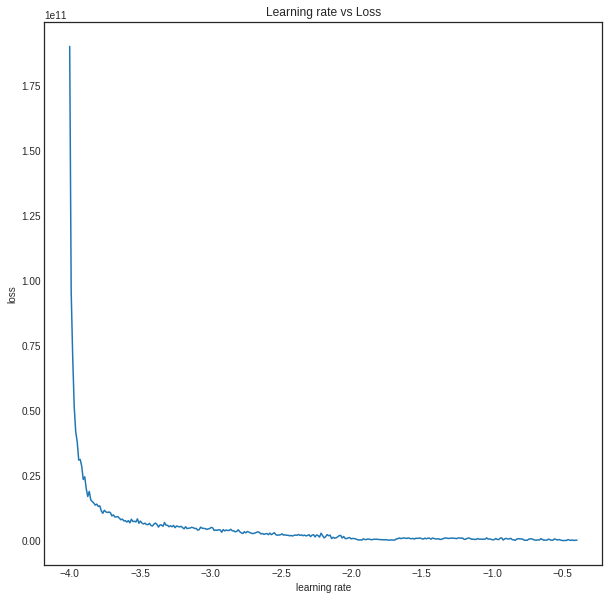

In [0]:
plt.figure(figsize=(10,10))
lr_callback.plot_schedule()

In [0]:
shuffle_model = ShuffleNetV2(input_shape=(28,28,1),classes=10)

In [0]:
shuffle_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [0]:
shuffle_history = shuffle_model.fit(trainX, trainY, 
                    epochs=1,
                    batch_size=128,
                    callbacks=[lr_callback],verbose=False)

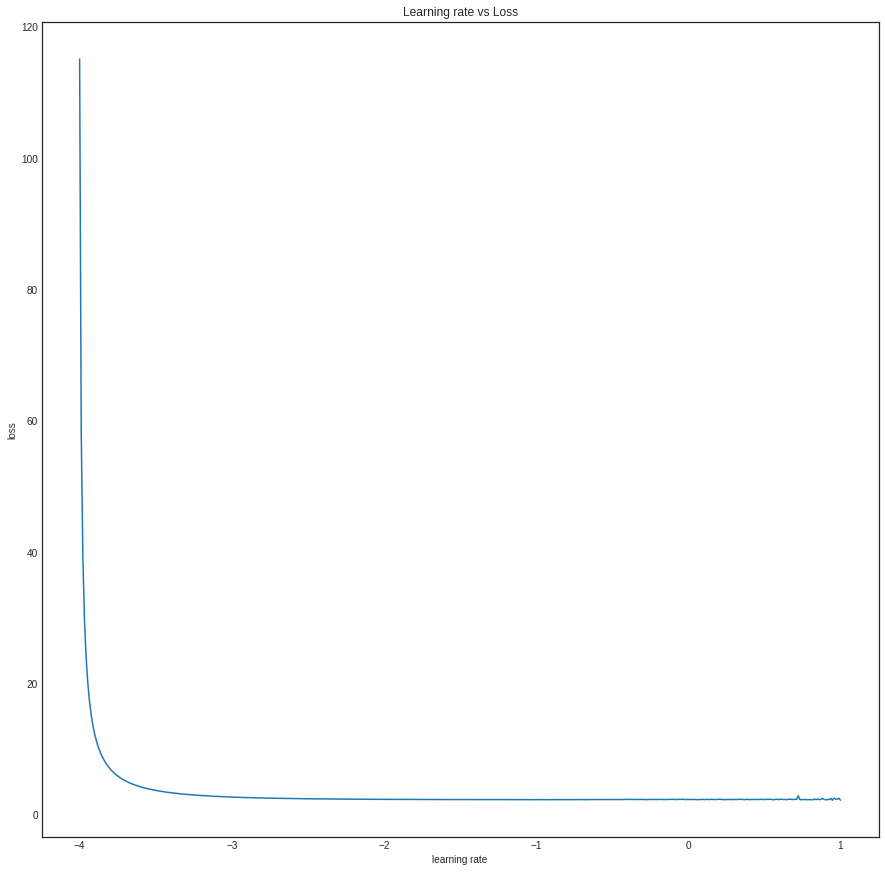

In [0]:
plt.figure(figsize=(15,15))
lr_callback.plot_schedule()

In [0]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        self.steps_per_epoch = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [0]:
scheduler = SGDRScheduler(min_lr=0.0003, max_lr=0.001, lr_decay=.9, cycle_length=3, mult_factor=1.5)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_with_cycling.h5', monitor='val_loss', save_best_only=True),
            scheduler]

epochs = 100

shuffle_model = ShuffleNetV2(input_shape=(28,28,1),classes=10)
shuffle_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

history_with_optimization = shuffle_model.fit(trainX, trainY, validation_split=0.1, epochs=80, batch_size=128, callbacks=callbacks)


Train on 54000 samples, validate on 6000 samples
Epoch 1/80
54000/54000 [==============================] - 22s 414us/sample - loss: 0.5748 - accuracy: 0.7916 - val_loss: 2.3389 - val_accuracy: 0.0942
Epoch 2/80
54000/54000 [==============================] - 14s 261us/sample - loss: 0.3474 - accuracy: 0.8727 - val_loss: 0.3735 - val_accuracy: 0.8645
Epoch 3/80
54000/54000 [==============================] - 14s 261us/sample - loss: 0.2578 - accuracy: 0.9041 - val_loss: 0.3533 - val_accuracy: 0.8730
Epoch 4/80
54000/54000 [==============================] - 14s 252us/sample - loss: 0.3146 - accuracy: 0.8855 - val_loss: 0.3948 - val_accuracy: 0.8710
Epoch 5/80
54000/54000 [==============================] - 14s 259us/sample - loss: 0.2621 - accuracy: 0.9039 - val_loss: 0.3302 - val_accuracy: 0.8902
Epoch 6/80
54000/54000 [==============================] - 14s 261us/sample - loss: 0.2167 - accuracy: 0.9203 - val_loss: 0.3203 - val_accuracy: 0.8845
Epoch 7/80
54000/54000 [=====================

In [0]:
shuffle_model.evaluate(testX,testY)


10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.5305901110678911, 0.8916]

In [0]:


shuffle_model = ShuffleNetV2(input_shape=(28,28,1),classes=10)
shuffle_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

history_with_optimization = shuffle_model.fit(trainX, trainY, validation_split=0.1, epochs=80, batch_size=128,callbacks=[EarlyStopping(monitor='val_loss', patience=10)])


Train on 54000 samples, validate on 6000 samples
Epoch 1/80
54000/54000 [==============================] - 21s 392us/sample - loss: 0.5736 - accuracy: 0.7885 - val_loss: 2.3562 - val_accuracy: 0.0942
Epoch 2/80
54000/54000 [==============================] - 13s 245us/sample - loss: 0.3590 - accuracy: 0.8687 - val_loss: 0.4071 - val_accuracy: 0.8513
Epoch 3/80
54000/54000 [==============================] - 13s 241us/sample - loss: 0.3022 - accuracy: 0.8903 - val_loss: 0.4007 - val_accuracy: 0.8657
Epoch 4/80
54000/54000 [==============================] - 13s 243us/sample - loss: 0.2675 - accuracy: 0.9026 - val_loss: 0.3689 - val_accuracy: 0.8738
Epoch 5/80
54000/54000 [==============================] - 13s 241us/sample - loss: 0.2495 - accuracy: 0.9082 - val_loss: 0.3585 - val_accuracy: 0.8778
Epoch 6/80
54000/54000 [==============================] - 13s 242us/sample - loss: 0.2327 - accuracy: 0.9157 - val_loss: 0.3156 - val_accuracy: 0.8922
Epoch 7/80
54000/54000 [=====================

In [0]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf


X_train, y_train = trainX,trainY
X_test, y_test = testX,testY

height,width = 56,56


	mobileNetV2.compile(loss=keras.losses.categorical_crossentropy,
		          optimizer=keras.optimizers.Adam(),
		          metrics=['accuracy'])

	return mobileNetV2
from tensorflow.keras.applications.MobileNetV2 import M


input_image = Input(shape=(height,width))
input_image_ = Lambda(lambda x: K.repeat_elements(K.expand_dims(x,3),3,3))(input_image)
base_model = MobileNet(input_tensor=input_image_, include_top=False, pooling='avg',weights=None,dep)
output = Dropout(0.5)(base_model.output)
predict = Dense(10, activation='softmax')(output)

model = Model(inputs=input_image, outputs=predict)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



X_train = X_train.reshape((X_train.shape[0], 28, 28,1))
X_train = tf.image.resize(X_train,(56,56))/255.
X_train=tf.image.grayscale_to_rgb(X_train)

X_test = X_test.reshape((X_test.shape[0], 28, 28,1))
X_test = tf.image.resize(X_test,(56,56))/255.
X_test=tf.image.grayscale_to_rgb(X_test)


model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test),steps_per_epoch=60000)

ValueError: ignored

In [0]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
trainX = trainX.reshape((trainX.shape[0], 28, 28,1))
testX = testX.reshape((testX.shape[0], 28, 28,1))

trainX=elli(trainX)/255.
testX=elli(testX)/255.


AttributeError: ignored

In [0]:

def resize_32x32(imgs):
    imgs = imgs.reshape((-1, 28, 28, 1))
    resized_imgs = np.zeros((imgs.shape[0], 32, 32, 1))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ..., 0] = transform.resize(imgs[i, ..., 0], (32, 32))
    return resized_imgs

In [0]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet

In [0]:
mobilnet = MobileNet(input_shape=(56,56,1),
                          alpha=1.0,
                          include_top=True,
                          weights=None,
                          input_tensor=None,
                          pooling=None,
                          classes=10)


In [0]:
mobilnet.compile(loss='categorical_crossentropy',
		          optimizer='adam',
		          metrics=['accuracy'])


In [0]:
mobilhistory = mobilnet.fit(trainX, trainY, validation_split=0, epochs=1, batch_size=128,callbacks=[EarlyStopping(monitor='val_loss', patience=10),lr_callback])


Train on 60000 samples
60000/60000 [==============================] - 81s 1ms/sample - loss: 1.0125 - acc: 0.1617


NameError: ignored

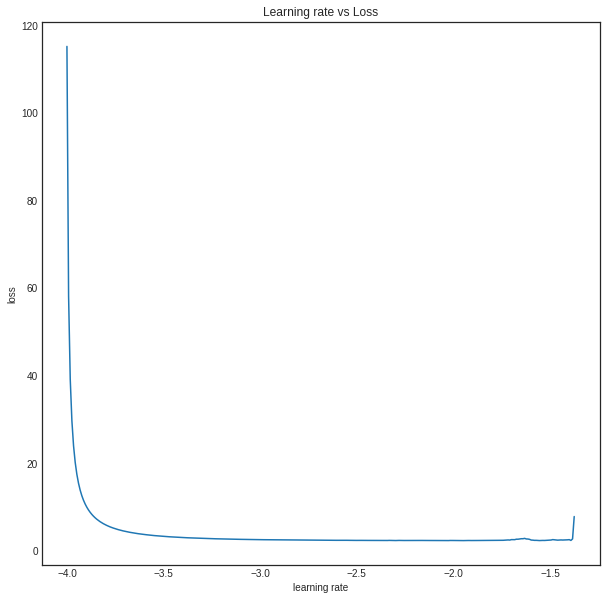

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
lr_callback.plot_schedule()

In [0]:
scheduler = SGDRScheduler(min_lr=0.0003, max_lr=0.001, lr_decay=.9, cycle_length=3, mult_factor=1.5)
swa = SWA(5,verbose=1)

callbacks = [swa]
mobilhistory = mobilnet.fit(trainX, trainY, validation_split=0.1, epochs=10, batch_size=128,callbacks=callbacks)
            

Train on 54000 samples, validate on 6000 samples
Model uses batch normalization. SWA will require last epoch to be a forward pass and will run with no learning rate
Epoch 1/10
54000/54000 [==============================] - 25s 471us/sample - loss: 0.6870 - acc: 0.7461 - val_loss: 2.5092 - val_acc: 0.1027
Epoch 2/10
54000/54000 [==============================] - 17s 318us/sample - loss: 0.3874 - acc: 0.8577 - val_loss: 1.0414 - val_acc: 0.6465
Epoch 3/10
54000/54000 [==============================] - 17s 317us/sample - loss: 0.3208 - acc: 0.8829 - val_loss: 0.3848 - val_acc: 0.8592
Epoch 4/10
54000/54000 [==============================] - 17s 316us/sample - loss: 0.2895 - acc: 0.8939 - val_loss: 0.3607 - val_acc: 0.8653

Epoch 00005: starting stochastic weight averaging
Epoch 5/10
54000/54000 [==============================] - 17s 318us/sample - loss: 0.2592 - acc: 0.9058 - val_loss: 0.4386 - val_acc: 0.8548
Epoch 6/10
54000/54000 [==============================] - 17s 321us/sample - lo

In [0]:
  mobilnet.evaluate(testX,testY)

10000/10000 [==============================] - 3s 305us/sample - loss: 0.2480 - acc: 0.9096


[0.2479996262550354, 0.9096]

In [0]:
mobilnet.evaluate(testX,testY)

10000/10000 [==============================] - 3s 296us/sample - loss: 17.9128 - acc: 0.3451


[17.91281450958252, 0.3451]

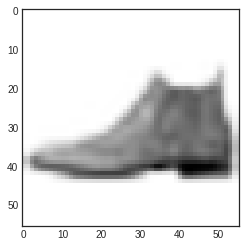

In [0]:
plt.imshow(testX[0,:,:,0])

In [0]:
mobilnet.predict(testX[4:6])

array([[3.34934443e-01, 2.59533850e-03, 1.08574778e-02, 3.20129860e-11,
        1.22501544e-04, 1.21197168e-04, 6.51050925e-01, 9.25178753e-11,
        3.18159058e-04, 5.56050372e-10],
       [1.71728826e-15, 9.99986410e-01, 1.35655955e-05, 4.04030520e-26,
        8.49804863e-16, 2.63033403e-16, 1.74961406e-10, 6.23894567e-32,
        1.89976879e-09, 3.82912566e-25]], dtype=float32)

In [0]:
testY[4:6]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
predicts = mobilnet.predict(testX)

In [0]:
print(classification_report(testY.argmax(axis=1), predicts.argmax(axis=1),
	target_names=labelNames))

              precision    recall  f1-score   support

         top       0.65      0.04      0.07      1000
     trouser       0.44      0.93      0.59      1000
    pullover       0.51      0.47      0.49      1000
       dress       0.00      0.00      0.00      1000
        coat       0.45      0.02      0.03      1000
      sandal       0.39      0.99      0.56      1000
       shirt       0.83      0.01      0.03      1000
     sneaker       0.00      0.00      0.00      1000
         bag       0.23      0.97      0.37      1000
  ankle boot       1.00      0.03      0.06      1000

    accuracy                           0.35     10000
   macro avg       0.45      0.35      0.22     10000
weighted avg       0.45      0.35      0.22     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
